# EfficientDet: Pytorch-lightning (with EfficientNet v2 backbone)

By Chris Hughes

The package versions used are:

In [1]:
# albumentations==1.0.0
# effdet==0.2.4
# ensemble-boxes==1.0.6
# fastcore==1.3.20
# pytorch-lightning==1.3.5
# timm==0.4.9
# torch==1.8.1

## Loading the data

As an example, we shall use the Kaggle cars object detection dataset found at https://www.kaggle.com/sshikamaru/car-object-detection. As this dataset is quite small, and the test set is unlabelled, for simplicity we shall focus on training and evaluating the model on the training set. Therefore, what this evaluation shows us is whether the model is capable of learning the task.

It is assumed that the data has been downloaded and unzipped at the following location (update where necessary):

In [2]:
from pathlib import Path

dataset_path = Path('./data-sources')
list(dataset_path.iterdir())

[WindowsPath('data-sources/sample_submission.csv'),
 WindowsPath('data-sources/testing_images'),
 WindowsPath('data-sources/training_images'),
 WindowsPath('data-sources/train_solution_bounding_boxes (1).csv')]

In [3]:
train_data_path = dataset_path/'training_images'

The annotations for this dataset are in the form of a csv file, which associates the image name with the corresponding annotations, we can view the format of this by loading it into a dataframe.

In [4]:
import pandas as pd

df = pd.read_csv(dataset_path/'train_solution_bounding_boxes (1).csv')

In [5]:
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


Here, we can see that each row associates the image filename with a bounding box in pascal VOC format. We only have a single class in this case, which is 'car'

## Dataset Adaptor



In order to use this in our model, we must first create a DatasetAdaptor, which will convert the raw dataset format into an image and corresponding annotations to feed into the model.

First, define some convenience functions so that we can plot images ang their corresponding bounding boxes

In [6]:
import matplotlib.pyplot as plt
from matplotlib import patches

def get_rectangle_edges_from_pascal_bbox(bbox):
    
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
    image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

Usually, at this point, we would create a PyTorch Dataset to feed this data into the training loop. However, some of this code, such as normalising the image and transforming the labels into the required format, are not specific to this problem and will need to be applied regardless of which dataset is being used. Therefore, let’s focus for now on creating a CarsDatasetAdaptor class, which will convert the specific raw dataset format into an image and corresponding annotations.  An implementation of this is presented below

In [7]:
from pathlib import Path

import PIL

import numpy as np

class CarsDatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.images = self.annotations_df.image.unique().tolist()

    def __len__(self) -> int:
        return len(self.images)

    def get_image_and_labels_by_idx(self, index):
        image_name = self.images[index]
        image = PIL.Image.open(self.images_dir_path / image_name)
        pascal_bboxes = self.annotations_df[self.annotations_df.image == image_name][
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = np.ones(len(pascal_bboxes))

        return image, pascal_bboxes, class_labels, index
    
    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes.tolist())
        print(class_labels)

the get_image_and_labels_by_idx method returns a tuple containing:

- image: A PIL image
- pascal_bboxes: a numpy array of shape [N, 4] containing the ground truth bounding boxes in Pascal VOC format
- class_labels: a numpy array of shape N containing the ground truth class labels
- image_id : a unique identifier which can be used to identify the image
and the __len__ method.


As we can see, in this case, this class simply wraps the dataframe provided with the dataset. We can now create an instance of this class to provide a clean interface to view the training data. As this dataset only contains a single class, ones are always returned in this case. Additionally, as the image_id can be any unique identifer associated with the image, here we have just used the index of the image in the dataset.

In [8]:
cars_train_ds = CarsDatasetAdaptor(train_data_path, df)

image_id: 0


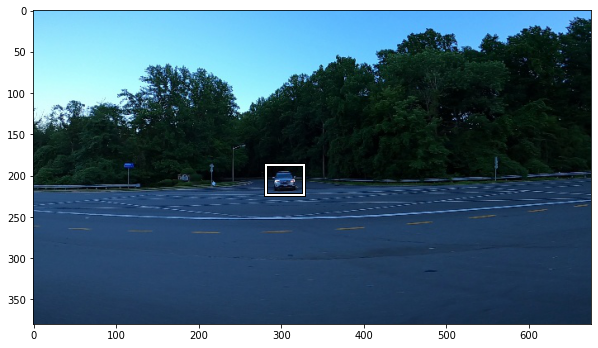

[1.]


In [9]:
cars_train_ds.show_image(0)

image_id: 3


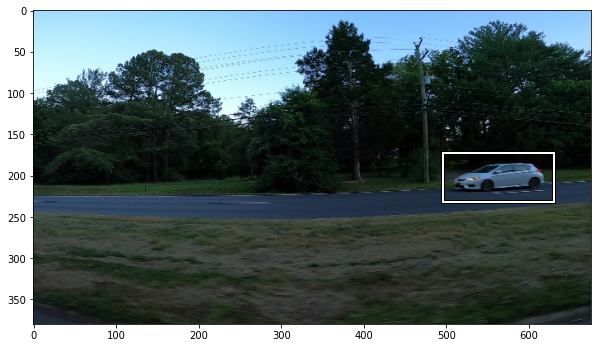

[1.]


In [10]:
cars_train_ds.show_image(3)

## Creating the model

There are several architecture variants available for EfficientDet, so we can view these as follows.

In [11]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

Now, let’s look at creating the EfficientDet model. Thanks to Ross Wightman’s effdet and timm libraries, we have many options here. The effdet package includes a selection of different EfficientDet configurations which can be used. We can view a selection of these below.

In [12]:
print(f'number of configs: {len(efficientdet_model_param_dict)}')

list(efficientdet_model_param_dict.keys())[:6]

number of configs: 44


['efficientdet_d0',
 'efficientdet_d1',
 'efficientdet_d2',
 'efficientdet_d3',
 'efficientdet_d4',
 'efficientdet_d5']


Some of these implementations (i.e. efficientdet_d5) have been trained by Ross in PyTorch, whereas any implementation prefixed by ‘tf_’ uses the official pretrained weights. As the initial models were trained in TensorFlow, to use these weights in PyTorch, certain modifications have been made (such as implementing ‘same’ padding) which means that these models may be slower during training and inference.

In addition to the provided configs, we can also use any model from timm as our EfficientDet backbone. Here, let’s try using one of the new EfficientNetv2 models as the backbone. Similarly to before, we can list these models using timm:


In [13]:
import timm

In [14]:
timm.list_models('tf_efficientnetv2_*')

['tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k']

To use one of these models, we first must register it as an EfficientDet config by adding a dictionary to the `efficientdet_model_param_dict`. Let’s create a function that does this for us, and then creates the EfficientDet model using the machinery from effdet:

In [15]:
def create_model(num_classes=1, image_size=512, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )
    
    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})
    
    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

We can now create an instance of the model. The model has parameters such as num_classes which should be set based on the specific problem.

Due to the architecture of EfficientDet, the input image size must be divisible by 128, see https://medium.com/@nainaakash012/efficientdet-scalable-and-efficient-object-detection-ea05ccd28427 for more details. Here, we use the default size of 512. Note that, when altering this, you must also alter the default transfroms which are used by the model, by passing new functions as parameters. This is easy to do, and will become straightforward after inspecting the source code.

## Define the EfficientDet Dataset

In [16]:
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
            :, [1, 0, 3, 2]
        ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

## Define the DataModule

In [17]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

class EfficientDetDataModule(LightningDataModule):
    
    def __init__(self,
                train_dataset_adaptor,
                validation_dataset_adaptor,
                train_transforms=get_train_transforms(target_img_size=512),
                valid_transforms=get_valid_transforms(target_img_size=512),
                num_workers=4,
                batch_size=8):
        
        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

    def train_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds, transforms=self.train_tfms
        )

    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return train_loader

    def val_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader
    
    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

ImportError: cannot import name 'get_num_classes'

## Define the training loop

In [ ]:
from numbers import Number
from typing import List
from functools import singledispatch

import numpy as np
import torch

from fastcore.dispatch import typedispatch
from pytorch_lightning import LightningModule
from pytorch_lightning.core.decorators import auto_move_data


from ensemble_boxes import ensemble_boxes_wbf


def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels


class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=1,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='tf_efficientnetv2_l',
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms


    @auto_move_data
    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)


    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log("train_loss", losses["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)
        self.log(
            "train_class_loss", losses["class_loss"], on_step=True, on_epoch=True, prog_bar=True,
            logger=True
        )
        self.log("train_box_loss", losses["box_loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)

        return losses['loss']


    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }

        self.log("valid_loss", outputs["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, sync_dist=True)
        self.log(
            "valid_class_loss", logging_losses["class_loss"], on_step=True, on_epoch=True,
            prog_bar=True, logger=True, sync_dist=True
        )
        self.log("valid_box_loss", logging_losses["box_loss"], on_step=True, on_epoch=True,
                 prog_bar=True, logger=True, sync_dist=True)

        return {'loss': outputs["loss"], 'batch_predictions': batch_predictions}
    
    
    @typedispatch
    def predict(self, images: List):
        """
        For making predictions from images
        Args:
            images: a list of PIL images

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        image_sizes = [(image.size[1], image.size[0]) for image in images]
        images_tensor = torch.stack(
            [
                self.inference_tfms(
                    image=np.array(image, dtype=np.float32),
                    labels=np.ones(1),
                    bboxes=np.array([[0, 0, 1, 1]]),
                )["image"]
                for image in images
            ]
        )

        return self._run_inference(images_tensor, image_sizes)

    @typedispatch
    def predict(self, images_tensor: torch.Tensor):
        """
        For making predictions from tensors returned from the model's dataloader
        Args:
            images_tensor: the images tensor returned from the dataloader

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        if images_tensor.ndim == 3:
            images_tensor = images_tensor.unsqueeze(0)
        if (
            images_tensor.shape[-1] != self.img_size
            or images_tensor.shape[-2] != self.img_size
        ):
            raise ValueError(
                f"Input tensors must be of shape (N, 3, {self.img_size}, {self.img_size})"
            )

        num_images = images_tensor.shape[0]
        image_sizes = [(self.img_size, self.img_size)] * num_images

        return self._run_inference(images_tensor, image_sizes)

    def _run_inference(self, images_tensor, image_sizes):
        dummy_targets = self._create_dummy_inference_targets(
            num_images=images_tensor.shape[0]
        )

        detections = self.model(images_tensor.to(self.device), dummy_targets)[
            "detections"
        ]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.__rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences
    
    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.img_size, self.img_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets
    
    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
            predictions, image_size=self.img_size, iou_thr=self.wbf_iou_threshold
        )

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(scores > self.prediction_confidence_threshold)[0]
        boxes = boxes[indexes]

        return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

    def __rescale_bboxes(self, predicted_bboxes, image_sizes):
        scaled_bboxes = []
        for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = img_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.img_size,
                            im_h / self.img_size,
                            im_w / self.img_size,
                            im_h / self.img_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes




In [18]:
dm = EfficientDetDataModule(train_dataset_adaptor=cars_train_ds, 
        validation_dataset_adaptor=cars_train_ds,
        num_workers=4,
        batch_size=2)

NameError: name 'EfficientDetDataModule' is not defined

In [ ]:
model = EfficientDetModel(
    num_classes=1,
    img_size=512
    )

As the EfficientDet model is just a standard PyTorch Lightning model, it can be trained in the usual way, by importing and creating an appropriate trainer.

In [ ]:
from pytorch_lightning import Trainer

In [ ]:
trainer = Trainer(
        gpus=[0], max_epochs=5, num_sanity_val_steps=1,
    )

In [ ]:
trainer.fit(model, dm)

We can save this like a regular PyTorch model

In [ ]:
torch.save(model.state_dict(), 'trained_effdet')

We can load our trained model again as follows

In [ ]:
model = EfficientDetModel(
    num_classes=1,
    img_size=512
    )

model.load_state_dict(torch.load('trained_effdet'))

## Using the model for inference

Now we have finetuned the model on our dataset, we can inspect some of the predictions. First we put the model into eval mode.

In [ ]:
model.eval()

We can now use our dataset adaptor to load a selection of images

In [ ]:
image1, truth_bboxes1, _, _ = cars_train_ds.get_image_and_labels_by_idx(0)
image2, truth_bboxes2, _, _ = cars_train_ds.get_image_and_labels_by_idx(1)

In [ ]:
images = [image1, image2]

and the model's predict function to get the predicted bounding boxes for these images

In [ ]:
predicted_bboxes, predicted_class_confidences, predicted_class_labels = model.predict(images)

We can visualise these predictions using a convenience function

In [ ]:
def compare_bboxes_for_image(
    image,
    predicted_bboxes,
    actual_bboxes,
    draw_bboxes_fn=draw_pascal_voc_bboxes,
    figsize=(20, 20),
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(image)
    ax1.set_title("Prediction")
    ax2.imshow(image)
    ax2.set_title("Actual")

    draw_bboxes_fn(ax1, predicted_bboxes)
    draw_bboxes_fn(ax2, actual_bboxes)

    plt.show()

In [ ]:
compare_bboxes_for_image(image1, predicted_bboxes=predicted_bboxes[0], actual_bboxes=truth_bboxes1.tolist())

In [ ]:
compare_bboxes_for_image(image2, predicted_bboxes=predicted_bboxes[1], actual_bboxes=truth_bboxes2.tolist())

## Using model hooks to manually debug

One feature of PyTorch lightning is that it uses methods or 'hooks' to represent each part of the training process. Whilst we lose some visibility over our training loop when using the Trainer, we can use these hooks to easily debug each step.

For example, we can use a hook defined on our DataModule to get the dataloader that will be used during validation and use this to grab a batch.

In [ ]:
loader = dm.val_dataloader()


In [ ]:
dl_iter = iter(loader)

In [ ]:
batch = next(dl_iter)

### Validation outputs and Coco metrics

We can use this batch to see exactly what the model calculated during validation. As lightning takes care of moving data to the correct device during training, for simplicity, we shall do this on the cpu so that we don't have to manually move all of the tensors in each batch to the device.

In [ ]:
device = model.device; device

Using the model's hook, we can see what is calculated for each batch during each validation step

In [ ]:
output = model.validation_step(batch=batch, batch_idx=0)

In [ ]:
output

Here, we can see that the loss is returned for the batch, as well as the predictions and targets.

In order to calculate metrics, for the epoch, we need to get the predictions corresponding to each batch. As the `validation_step` method will be called for each batch, let's define a function to aggregate the outputs. 

Here, for simplicity, we will patch this function to the EfficientDet class using a convenience decorator from fastcore - we pay a huge performance price for Python being a dynamic language, we may as well make the most of it!

In [ ]:
from fastcore.basics import patch

@patch
def aggregate_prediction_outputs(self: EfficientDetModel, outputs):

    detections = torch.cat(
        [output["batch_predictions"]["predictions"] for output in outputs]
    )

    image_ids = []
    targets = []
    for output in outputs:
        batch_predictions = output["batch_predictions"]
        image_ids.extend(batch_predictions["image_ids"])
        targets.extend(batch_predictions["targets"])

    (
        predicted_bboxes,
        predicted_class_confidences,
        predicted_class_labels,
    ) = self.post_process_detections(detections)

    return (
        predicted_class_labels,
        image_ids,
        predicted_bboxes,
        predicted_class_confidences,
        targets,
    )

From the PyTorch-lightning docs (see https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#validation-epoch-level-metrics), we can see that we can add an additional hook `validation_epoch_end` which is called after all batches have been processed; at the end of each epoch, a list of step outputs are passed to this hook.

Let's use this hook to calculate the overall validation loss, as well as the COCO metrics using the `objdetecteval` package. we can use the output that we just calculated when evaluating a single validation batch, but this approach would also extend to the validation loop evaluation during training with lightning.

In [ ]:
!pip install git+https://github.com/alexhock/object-detection-metrics

In [ ]:
from objdetecteval.metrics.coco_metrics import get_coco_stats

In [ ]:
@patch
def validation_epoch_end(self: EfficientDetModel, outputs):
    """Compute and log training loss and accuracy at the epoch level."""

    validation_loss_mean = torch.stack(
        [output["loss"] for output in outputs]
    ).mean()

    (
        predicted_class_labels,
        image_ids,
        predicted_bboxes,
        predicted_class_confidences,
        targets,
    ) = self.aggregate_prediction_outputs(outputs)

    truth_image_ids = [target["image_id"].detach().item() for target in targets]
    truth_boxes = [
        target["bboxes"].detach()[:, [1, 0, 3, 2]].tolist() for target in targets
    ] # convert to xyxy for evaluation
    truth_labels = [target["labels"].detach().tolist() for target in targets]

    stats = get_coco_stats(
        prediction_image_ids=image_ids,
        predicted_class_confidences=predicted_class_confidences,
        predicted_bboxes=predicted_bboxes,
        predicted_class_labels=predicted_class_labels,
        target_image_ids=truth_image_ids,
        target_bboxes=truth_boxes,
        target_class_labels=truth_labels,
    )['All']

    return {"val_loss": validation_loss_mean, "metrics": stats}

In [ ]:
model.validation_epoch_end([output])

### For inference

We can also use the predict function directly on the processed images returned from our data loader. Let's  now unpack the batch to just get the images, as we don't need the labels for inference.

In [ ]:
images, annotations,targets, image_ids = batch

Thanks to the `typedispatch` decorator, we can use the same predict function signature on these tensors.

In [ ]:
predicted_bboxes, predicted_class_labels, predicted_class_confidences = model.predict(images)

It is important to note at this point that the images given by the dataloader have already been transformed and scaled to size 512. Therefore, the bounding boxes predicted will be relative for an image of 512. As such, to visualise these predictions on the original image, we must rescale it.

In [ ]:
image, _, _, _ = cars_train_ds.get_image_and_labels_by_idx(0)

In [ ]:
show_image(image.resize((512, 512)), predicted_bboxes[0])

As we can see, after rescaling, the bounding box is in the correct position!